# 02 Same Length

Here I test the LSTM to see how well it will learn on different length strings. I will train the LSTM on strings all of the same length $k$, and then test the LSTM on strings all of the same length $k$. I will then vary $k$ from 12 to 128.

**Results: The results are in the plots below. They need to be written about, and potentially more tests should be done. The massive spikes are likely due to bad initializations. Also, we need to account for increasing string length. Also, the 2 hidden case is more jaggedy because it has more datapoints, not because it's bad.**

*The next thing to test would be the instance where you train the LSTM on all strings of length $\le k$, test the LSTM on all strings of length $\le k$ and then gradually increase $k$.*

*My testing protocol is to generate 100,000 random strings, remove duplicates, partitition among train, val, test at 70%-20%-10%, and train until the validation loss has less than a $0.001$ decrease for more than 10 epochs*

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%cd drive/My\ Drive/CS281\ Final\ Project

## Package Loading

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from sklearn.model_selection import train_test_split
device = 'cuda'

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Model Definition

In [0]:
class Counter():
    def __init__(self, hidden):
        '''hidden is the number of hidden variables to use per cell'''

        #this LSTM goes from input [batch x length x 1] to output [batch x length x hidden]
        self.lstm = nn.LSTM(1, hidden, batch_first=True).double().cuda() 

        #this matrix transforms from [1 x hidden] to [1 x 1]
        self.combine = torch.randn([hidden,1], dtype=float, device=device, requires_grad=True) 

        params = list(self.lstm.parameters())
        params.append(self.combine)
        self.optimizer = optim.Adam(params)

    @staticmethod
    def convert_sequence(seq):
        '''converts a set of sequences with the same length from array or numpy into a correctly formatted tensor.
        Shape: [batch x length x 1]'''
        seq = torch.tensor(seq, device=device).double()
        seq = seq.reshape([len(seq), -1, 1])
        return seq

    def predict(self, sequence):
        '''takes a tensor, predicts the sum of the tensor, and compares to the actual sum of the tensor. 
        Returns the loss and the predicted sum'''
        pred, _ = self.lstm(sequence)
        pred = pred[:,-1,:] @ self.combine 
        #the second index is the rolling output. The final output is the last element in that index

        loss = (pred - sequence.sum(1)).pow(2)
        return loss, pred

## Model Testing

I did some testing, and I'm pretty sure that the validation set isn't leaking gradients into the train set. 

In [0]:
#generate all the strings and partition into train and test
length = 16

for length in range(16,129,4):
    print(length)
    depth = 100000
    seqs = np.random.randint(0,2, size=[depth,length])
    seqs = np.unique(seqs, axis=0)

    train, test = train_test_split(seqs, test_size=0.1, shuffle=True)
    train, val = train_test_split(train, test_size=0.22, shuffle=True)
    train = Counter.convert_sequence(train)
    val = Counter.convert_sequence(val)
    test  = Counter.convert_sequence(test)

    print(train.shape, train.shape[0]/seqs.shape[0])
    print(val.shape, val.shape[0]/seqs.shape[0])
    print(test.shape, test.shape[0]/seqs.shape[0])


    #train over all the training data
    model = Counter(hidden=2)

    history = []
    best = float('inf')
    patience = 10
    tol = 0.001
    count = 0

    for epoch in range(1000000): 
        if epoch % 100 == 0:
            train_loss = model.predict(train)[0].mean().item()
            with torch.no_grad():
                val_loss = model.predict(val)[0].mean().item()
            history.append([train_loss, val_loss])
            print("Epoch: %5d. Train Loss: %7.3f. Validation Loss: %7.3f"%(epoch, train_loss, val_loss))

            if val_loss + tol< best:
                best = val_loss
                count = 0
            else:
                count += 1
            if count >= patience:
                break

        #take the average loss over all the train data
        loss = model.predict(train)[0].mean()   
        #and update
        model.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        model.optimizer.step()
    history = np.array(history)
    np.save("Part-2-Outputs/Train-%d"%length, history)
    torch.save(model, "Part-2-Outputs/Model-%d"%length)

    #display testing results
    loss, pred = model.predict(test)
    print("Average Test Loss:", loss.mean().item())

    with open("Part-2-Outputs/TrainResults.txt", 'a') as f:
        f.write("%3d %9.5f\n"%(length, loss.mean().item()))

    print('\n\n\n')

## Results

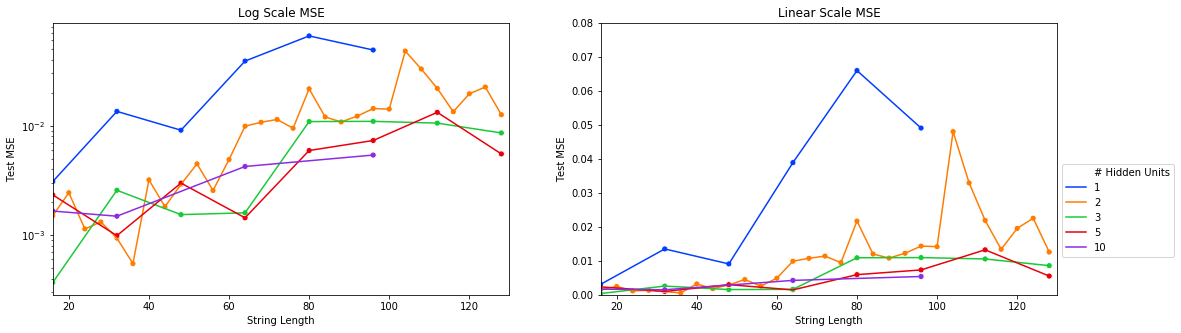

In [0]:
results = pd.read_table("Part-2-Outputs/AllResults.txt", sep="\s+", header=None)
results.columns=["# Hidden Units", "String Length", "Test MSE"]
results = results[results['String Length'] <= 128]
results = results[results['Test MSE'] < 1]

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
sns.lineplot(x="String Length", y='Test MSE', hue='# Hidden Units', data=results, palette=sns.color_palette("bright", 5), legend=False)
sns.scatterplot(x="String Length", y='Test MSE', hue='# Hidden Units', data=results, palette=sns.color_palette("bright", 5),legend=False)
# plt.ylim([0,.1])
plt.yscale("log")
plt.xlim([16,130])
plt.title("Log Scale MSE")

plt.subplot(1,2,2)
sns.lineplot(x="String Length", y='Test MSE', hue='# Hidden Units', data=results, palette=sns.color_palette("bright", 5))
sns.scatterplot(x="String Length", y='Test MSE', hue='# Hidden Units', data=results, palette=sns.color_palette("bright", 5),legend=False)
plt.ylim([0,.08])
plt.xlim([16,130])
plt.legend(bbox_to_anchor=(1, .5))
plt.title("Linear Scale MSE")
plt.savefig("Figures/Samelength-Compare.png", dpi=300)
plt.show()